In [ ]:
import shutil
import numpy as np
from PIL import Image
import albumentations as A
from sklearn.model_selection import train_test_split

# Пути к исходным изображениям
input_otitis = '/content/drive/MyDrive/final project/problem'  # Отит
input_normal = '/content/drive/MyDrive/final project/Normal'   # Норма

# Создание директорий dataset
base_dir = '/content/drive/MyDrive/final project/dataset'
for folder in ['train/otitis', 'train/normal', 'val/otitis', 'val/normal', 'test/otitis', 'test/normal']:
    os.makedirs(os.path.join(base_dir, folder), exist_ok=True)

In [ ]:


# Сбор путей ко всем изображениям и их меток
all_images, all_labels = [], []
for label, path in zip(['otitis', 'normal'], [input_otitis, input_normal]):
    for file_name in os.listdir(path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            all_images.append(os.path.join(path, file_name))
            # label == 1 для отита, label == 0 для нормы
            all_labels.append(1 if label == 'otitis' else 0)

# Разделение на выборки
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Описание аугментаций (применяется только к train и только к отиту)
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.3),
])

def process_and_save(images, labels, folder):
    """
    Сохраняет изображения в папки train/val/test,
    а для train дополнительно делает аугментацию ТОЛЬКО для отита (label == 1).
    """
    counter = 0  # счётчик для названий аугментированных файлов
    for img_path, label in zip(images, labels):
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)

        # Определяем конечную директорию: otitis или normal
        class_subfolder = 'otitis' if label == 1 else 'normal'
        dest_folder = os.path.join(base_dir, folder, class_subfolder)

        # Сохраняем оригинальное изображение
        original_name = os.path.basename(img_path)
        Image.fromarray(img_array).save(os.path.join(dest_folder, original_name))

        # Если это обучающая выборка и отит (label == 1), делаем аугментации
        if folder == 'train' and label == 1:
            for _ in range(5):
                aug_img = augmentations(image=img_array)['image']
                aug_name = f'aug_{counter}.tiff'
                Image.fromarray(aug_img).save(os.path.join(dest_folder, aug_name))
                counter += 1

# Применяем функцию ко всем трём выборкам
process_and_save(X_train, y_train, 'train')
process_and_save(X_val, y_val, 'val')
process_and_save(X_test, y_test, 'test')

print('Подготовка данных завершена.')


Подготовка данных завершена.


In [ ]:
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Функция для загрузки изображений, изменения размера и конвертации меток
def load_and_prepare_images(image_dir, target_size=(128, 128)):
    images = []
    labels = []
    for label_folder in ['otitis', 'normal']:
        folder_path = os.path.join(image_dir, label_folder)
        for file_name in os.listdir(folder_path):
            if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img = load_img(os.path.join(folder_path, file_name), target_size=target_size)
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(1 if label_folder == 'otitis' else 0)
    return np.array(images), np.array(labels)

# Загрузка данных из подготовленных папок
train_dir = '/content/drive/MyDrive/final project/dataset/train'
val_dir = '/content/drive/MyDrive/final project/dataset/val'
test_dir = '/content/drive/MyDrive/final project/dataset/test'

X_train, y_train = load_and_prepare_images(train_dir)
X_val, y_val = load_and_prepare_images(val_dir)
X_test, y_test = load_and_prepare_images(test_dir)

print('Все изображения загружены, изменены до 128x128 и метки конвертированы в числовой формат.')

Все изображения загружены, изменены до 128x128 и метки конвертированы в числовой формат.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Создание модели model1
model2 = Sequential()

# Первый сверточный блок
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Второй сверточный блок
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Третий сверточный блок
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Четвёртый сверточный блок (новый)
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Преобразование в вектор
model2.add(Flatten())

# Полносвязные слои
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))  # Dropout для регуляризации
model2.add(Dense(1, activation='sigmoid'))  # Сигмоид для бинарной классификации

# Компиляция модели
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Вывод структуры модели
model2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,748,225 (10.48 MB)

 Trainable params: 2,748,225 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    verbose=1
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.6483 - loss: 0.6074 - val_accuracy: 0.7727 - val_loss: 0.5506
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8195 - loss: 0.3672 - val_accuracy: 0.6636 - val_loss: 0.6305
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8600 - loss: 0.3191 - val_accuracy: 0.8000 - val_loss: 0.4382
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8584 - loss: 0.3029 - val_accuracy: 0.8273 - val_loss: 0.3997
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8736 - loss: 0.2956 - val_accuracy: 0.7818 - val_loss: 0.4717
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8649 - loss: 0.2864 - val_accuracy: 0.6818 - val_loss: 0.6216
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8518 - loss: 0.2955 - val_accuracy: 0.8000 - val_loss: 0.4317
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8932 - loss: 0.2574 - val_accuracy: 0.8636 - 

In [ ]:
# Оценка на тестовой выборке
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=1)
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7495 - loss: 0.5615
Точность на тестовой выборке: 0.7748


In [ ]:
# Сохраняем модель
model2.save('/content/drive/MyDrive/my_modelfinal.h5')
print("Модель сохранена на Google Диск.")

Модель сохранена на Google Диск.


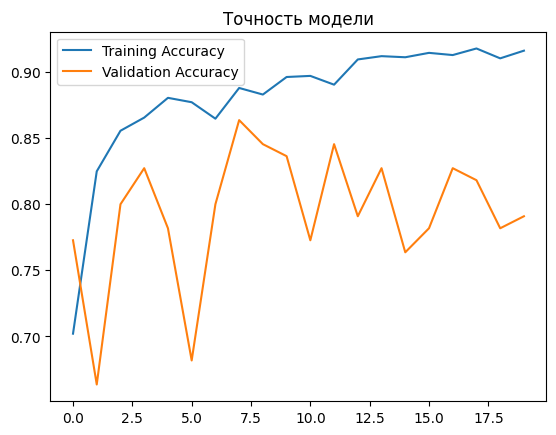

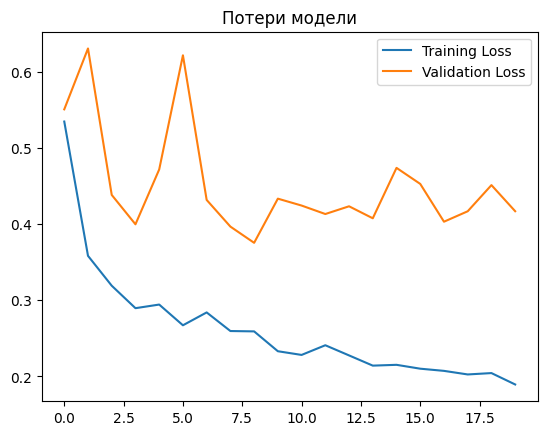

In [ ]:
import matplotlib.pyplot as plt

# График точности
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Точность модели')
plt.show()

# График потерь
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Потери модели')
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
Матрица ошибок:
[[69 15]
 [10 17]]

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85        84
           1       0.53      0.63      0.58        27

    accuracy                           0.77       111
   macro avg       0.70      0.73      0.71       111
weighted avg       0.79      0.77      0.78       111



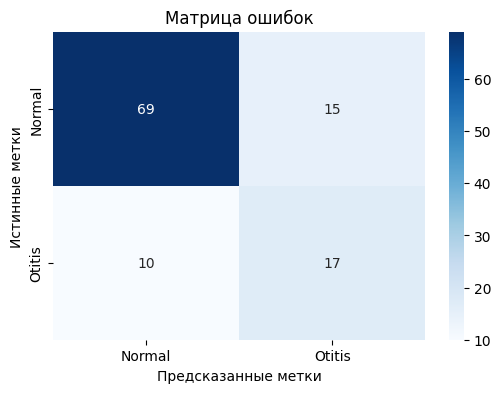

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_prob = model2.predict(X_test)  # Предсказанные вероятности
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Преобразуем в бинарные метки

# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
print("Матрица ошибок:")
print(cm)


print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred))


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Otitis'],
            yticklabels=['Normal', 'Otitis'])
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Создание модели model1
model6 = Sequential()

# Первый сверточный блок
model6.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# Второй сверточный блок
model6.add(Conv2D(64, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# Третий сверточный блок
model6.add(Conv2D(128, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# Четвёртый сверточный блок (новый)
model6.add(Conv2D(256, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# Преобразование в вектор
model6.add(Flatten())

# Полносвязные слои
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.5))  # Dropout для регуляризации
model6.add(Dense(1, activation='sigmoid'))  # Сигмоид для бинарной классификации

# Компиляция модели
model6.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Вывод структуры модели
model6.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,748,225 (10.48 MB)

 Trainable params: 2,748,225 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class_weight = {0: 1.0, 1: 2.0}
model6.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=20,
          class_weight=class_weight)


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.6335 - loss: 0.8656 - val_accuracy: 0.3364 - val_loss: 0.8011
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7770 - loss: 0.4884 - val_accuracy: 0.7909 - val_loss: 0.5043
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8178 - loss: 0.4819 - val_accuracy: 0.7727 - val_loss: 0.4929
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8422 - loss: 0.4285 - val_accuracy: 0.7273 - val_loss: 0.5394
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8588 - loss: 0.3982 - val_accuracy: 0.7727 - val_loss: 0.5174
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8496 - loss: 0.3947 - val_accuracy: 0.7727 - val_loss: 0.4900
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8511 - loss: 0.3982 - val_accuracy: 0.7636 - val_loss: 0.4916
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8673 - loss: 0.3506 - val_accuracy: 0.7818 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Матрица ошибок:
[[60 24]
 [ 5 22]]

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.92      0.71      0.81        84
           1       0.48      0.81      0.60        27

    accuracy                           0.74       111
   macro avg       0.70      0.76      0.70       111
weighted avg       0.81      0.74      0.76       111



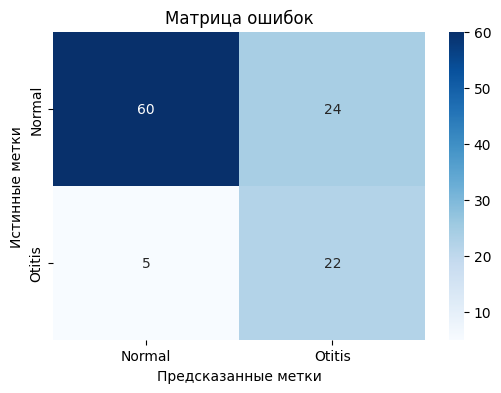

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_prob = model6.predict(X_test)  # Предсказанные вероятности
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Преобразуем в бинарные метки

# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
print("Матрица ошибок:")
print(cm)


print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred))


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Otitis'],
            yticklabels=['Normal', 'Otitis'])
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()


In [ ]:
test_loss, test_accuracy = model6.evaluate(X_test, y_test, verbose=1)
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7538 - loss: 0.5517
Точность на тестовой выборке: 0.7387


In [ ]:
# Сохраняем модель
model6.save('/content/drive/MyDrive/best.h5')
print("Модель сохранена на Google Диск.")

Модель сохранена на Google Диск.
